## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Коновалов Михаил Анатольевич

In [92]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline
from scipy import stats

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [3]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [4]:
images_train, labels_train = next(iter(train_loader))

In [5]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

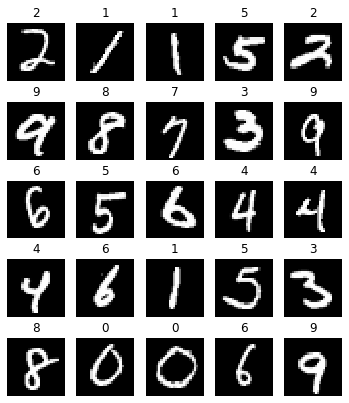

In [6]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [55]:
def init_layer(layer, mean=0, std=0.1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

In [70]:
layers = []
sizes = [28*28, 64, 32] + [16] * 20 + [10]

for insize, outsize in zip(sizes, sizes[1:]):
    layer = nn.Linear(insize, outsize)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer)
    
    layers.append(layer)
    layers.append(nn.Tanh())
    
del layers[-1]

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [71]:
network = nn.Sequential(*layers)

batch_size = 100
loss = nn.NLLLoss()
optim = torch.optim.Adam(network.parameters(), lr=1e-3)

X = images_train[:batch_size].reshape(batch_size, -1).data
y = labels_train[:batch_size].data

result = network(X)
loss_value = loss(result, y)
loss_value.backward()

forward 0.9674385190010071
forward 0.8417056798934937
forward 0.5111410617828369
forward 0.2779307961463928
forward 0.11676657199859619
forward 0.04231956973671913
forward 0.0187228936702013
forward 0.0075302948243916035
forward 0.0035938331857323647
forward 0.0012621673522517085
forward 0.00045944482553750277
forward 0.0001702512672636658
forward 5.564594903262332e-05
forward 2.256389234389644e-05
forward 1.1105184057669248e-05
forward 5.15154442837229e-06
forward 2.2648964659310877e-06
forward 1.0639714673743583e-06
forward 4.2962906832144654e-07
forward 1.1803282973232854e-07
forward 5.9529529750079746e-08
forward 2.755907324569762e-08
forward 1.3952245581094758e-08
backward 0.032317861914634705
backward 0.03396540880203247
backward 0.012549261562526226
backward 0.0040932949632406235
backward 0.002457408932968974
backward 0.0010011132108047605
backward 0.00048445345601066947
backward 0.00015346118016168475
backward 6.431222573155537e-05
backward 2.4777846192591824e-05
backward 1.476

<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [75]:
def xavier(insize, outsize):
    return np.sqrt(2 / (insize + outsize))

def he(insize, outsize):
    return np.sqrt(2 / outsize)

In [76]:
init_function = xavier

layers = []
sizes = [28*28, 64, 32] + [16] * 20 + [10]

for insize, outsize in zip(sizes, sizes[1:]):
    layer = nn.Linear(insize, outsize)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, 0.0, std=init_function(insize, outsize))
    
    layers.append(layer)
    layers.append(nn.Tanh())

del layers[-1]


network = nn.Sequential(*layers)

batch_size = 100
loss = nn.NLLLoss()
optim = torch.optim.Adam(network.parameters(), lr=1e-3)

X = images_train[:batch_size].reshape(batch_size, -1).data
y = labels_train[:batch_size].data

result = network(X)
loss_value = loss(result, y)
loss_value.backward()

forward 0.9674385190010071
forward 0.7007105350494385
forward 0.5578444004058838
forward 0.5025557279586792
forward 0.42043447494506836
forward 0.38831138610839844
forward 0.3010959029197693
forward 0.28954681754112244
forward 0.24660395085811615
forward 0.2405339926481247
forward 0.22650232911109924
forward 0.2406262904405594
forward 0.18585042655467987
forward 0.16224360466003418
forward 0.16130557656288147
forward 0.14511960744857788
forward 0.1335664540529251
forward 0.1258382350206375
forward 0.14121177792549133
forward 0.14455434679985046
forward 0.13771386444568634
forward 0.1437382996082306
forward 0.1604374796152115
backward 0.032317861914634705
backward 0.11512044817209244
backward 0.08565767854452133
backward 0.08900627493858337
backward 0.08983481675386429
backward 0.08874518424272537
backward 0.076560378074646
backward 0.07384292036294937
backward 0.09097039699554443
backward 0.09102443605661392
backward 0.1047649011015892
backward 0.11479507386684418
backward 0.0945229008

In [79]:
init_function = he

layers = []
sizes = [28*28, 64, 32] + [16] * 20 + [10]

for insize, outsize in zip(sizes, sizes[1:]):
    layer = nn.Linear(insize, outsize)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, std=init_function(insize, outsize))
    
    layers.append(layer)
    layers.append(nn.Tanh())
    
del layers[-1]


network = nn.Sequential(*layers)

batch_size = 100
loss = nn.NLLLoss()
optim = torch.optim.Adam(network.parameters(), lr=1e-3)

X = images_train[:batch_size].reshape(batch_size, -1).data
y = labels_train[:batch_size].data

result = network(X)
loss_value = loss(result, y)
loss_value.backward()

forward 0.9674385190010071
forward 0.9071714282035828
forward 0.7629152536392212
forward 0.7287699580192566
forward 0.6417555212974548
forward 0.5908160209655762
forward 0.6116660237312317
forward 0.5263339281082153
forward 0.5291524529457092
forward 0.5551007390022278
forward 0.5786155462265015
forward 0.5096825361251831
forward 0.5254874229431152
forward 0.6002951264381409
forward 0.5075657963752747
forward 0.5198096632957458
forward 0.5247715711593628
forward 0.5245132446289062
forward 0.5218653678894043
forward 0.5801065564155579
forward 0.5867525935173035
forward 0.6705632209777832
forward 0.6693671941757202
backward 0.032317861914634705
backward 0.06841659545898438
backward 0.07850893586874008
backward 0.11268890649080276
backward 0.08868025988340378
backward 0.125416561961174
backward 0.11424942314624786
backward 0.11733126640319824
backward 0.09860745072364807
backward 0.10015497356653214
backward 0.10970194637775421
backward 0.09141432493925095
backward 0.1581084132194519
back

Посмотрим, как ведет себя дисперсия в случае ReLU.

In [80]:
init_function = he

layers = []
sizes = [28*28, 64, 32] + [16] * 20 + [10]

for insize, outsize in zip(sizes, sizes[1:]):
    layer = nn.Linear(insize, outsize)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, std=init_function(insize, outsize))
    
    layers.append(layer)
    layers.append(nn.ReLU())
    
del layers[-1]


network = nn.Sequential(*layers)

batch_size = 100
loss = nn.NLLLoss()
optim = torch.optim.Adam(network.parameters(), lr=1e-3)

X = images_train[:batch_size].reshape(batch_size, -1).data
y = labels_train[:batch_size].data

result = network(X)
loss_value = loss(result, y)
loss_value.backward()

forward 0.9674385190010071
forward 2.7410099506378174
forward 3.8437626361846924
forward 4.3732500076293945
forward 4.581939697265625
forward 4.019128799438477
forward 3.517737865447998
forward 2.7494661808013916
forward 2.8427371978759766
forward 4.087477207183838
forward 3.8653788566589355
forward 2.8342723846435547
forward 3.6300995349884033
forward 4.472577095031738
forward 4.682651042938232
forward 3.073713779449463
forward 3.0858192443847656
forward 2.8360564708709717
forward 2.19234561920166
forward 2.4067420959472656
forward 3.0688490867614746
forward 2.9651331901550293
forward 3.036822557449341
backward 0.032317861914634705
backward 0.06399337947368622
backward 0.035681068897247314
backward 0.025576898828148842
backward 0.032743167132139206
backward 0.03709203004837036
backward 0.018056919798254967
backward 0.020382653921842575
backward 0.015734411776065826
backward 0.032873183488845825
backward 0.027593690901994705
backward 0.03179285302758217
backward 0.028863931074738503
ba

<i> 1.4 Сделайте выводы по первой части </i>

При инициализации весов линейных слоев путем сэмплирования из нормального распределения с дисперсией 0.1 наблюдается сильное уменьшение дисперсии при проходе данных и градиента через сеть. Инициализация по методам Ксавьера и He дают более устойчивую дисперсию весов. Тем не менее, дисперсия немного уменьшается, так как эти методы используют довольно сильное допущение, что большая часть данных и градиентов проходит через линейную область функции активации. В случае ReLU инициализация He показывает очень хороший результат в силу линейности положительной области определения ReLU.

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

In [182]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        mask = torch.zeros_like(self.linear.weight) + self.p
        if self.training:          
            mask.bernoulli_()

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [189]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()    
        
        channels = 1
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),    
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),            
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()
        
        self.final_part = final_part
        
        self.log_softmax = nn.LogSoftmax(1)        
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Epoch 9... (Train/Test) NLL: 0.054/0.082	Accuracy: 0.982/0.974


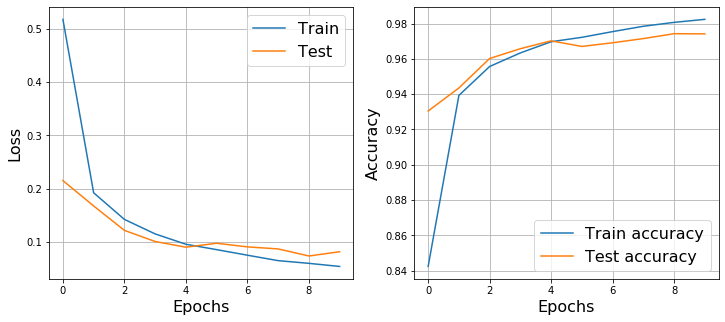

([0.5175328336036535,
  0.1922994854131233,
  0.14242763940427602,
  0.11523128821572134,
  0.09581624868629711,
  0.08573443516453447,
  0.0753019058477205,
  0.06509645602135643,
  0.06002632881214878,
  0.054207242795947325],
 [0.2152269708959362,
  0.167630652555182,
  0.1218439017339975,
  0.10097979103462605,
  0.0903068583788751,
  0.09769434701722068,
  0.09089179983056045,
  0.08707401065650998,
  0.07382541607263722,
  0.08175941252538675],
 [0.8423952,
  0.9393102,
  0.95570695,
  0.9633973,
  0.9697273,
  0.972237,
  0.9754631,
  0.9785003,
  0.9807048,
  0.9824149],
 [0.93047863,
  0.9435324,
  0.96024525,
  0.96578324,
  0.9702334,
  0.96706885,
  0.9691456,
  0.971519,
  0.974288,
  0.9741891])

In [195]:
from train_utils import train

layers = [
    nn.Linear(196, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
]

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001)

Epoch 9... (Train/Test) NLL: 0.109/0.064	Accuracy: 0.969/0.979


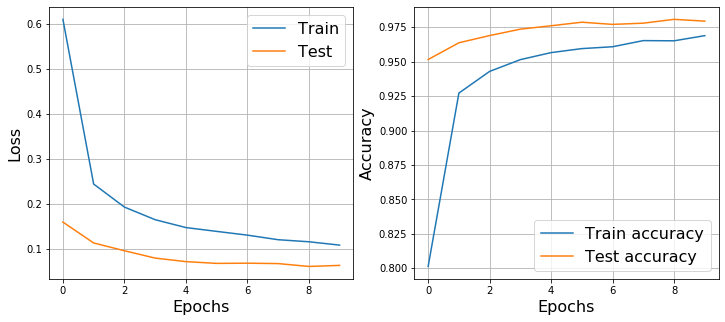

([0.6093119642119418,
  0.2443537863491695,
  0.19334982502371517,
  0.16535132333064384,
  0.14791279485119557,
  0.13947475388614353,
  0.13114620089086135,
  0.12099993034307636,
  0.1164544285225398,
  0.10902147049477487],
 [0.1600355314963226,
  0.11382018477667737,
  0.09657523545283306,
  0.08028092578973008,
  0.0724535929068593,
  0.06853281535632626,
  0.06896179148785864,
  0.06811649235602044,
  0.06176128836725898,
  0.06407532691837678],
 [0.80129486,
  0.9271777,
  0.94293046,
  0.95147586,
  0.95656765,
  0.9594771,
  0.960832,
  0.9652852,
  0.9651408,
  0.9688833],
 [0.95154274,
  0.9637065,
  0.96894777,
  0.97359574,
  0.976068,
  0.97863925,
  0.977057,
  0.977947,
  0.980716,
  0.9794304])

In [196]:
from train_utils import train

layers = [
    nn.Linear(196, 128),
    nn.Dropout(p=0.5),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.Dropout(p=0.5),
    nn.ReLU(),
    nn.Linear(128, 10)
]

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001)

Epoch 9... (Train/Test) NLL: 0.170/0.104	Accuracy: 0.947/0.966


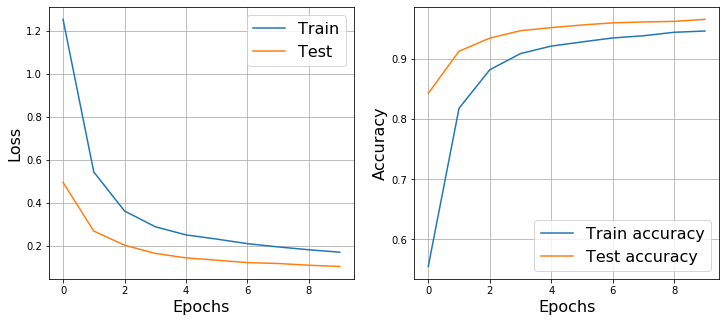

([1.2556340227376168,
  0.5444518997788683,
  0.3624122564885408,
  0.2890477766836884,
  0.25108230090154005,
  0.2315052516424834,
  0.21016549635956536,
  0.1949814843820102,
  0.18171441342943767,
  0.17043050214934197],
 [0.4959905296564102,
  0.2689521834254265,
  0.20312223177921923,
  0.16480728205812128,
  0.1438822530775885,
  0.13315217725083797,
  0.12184801506750946,
  0.11768077526100074,
  0.10965514814929117,
  0.10402324302947219],
 [0.5548874,
  0.8181858,
  0.88244605,
  0.9093817,
  0.9218584,
  0.92877686,
  0.93540114,
  0.9390492,
  0.9448627,
  0.94693387],
 [0.84315664,
  0.91327137,
  0.9351266,
  0.9474881,
  0.9526305,
  0.9569818,
  0.9605419,
  0.96202534,
  0.96301425,
  0.9663766])

In [197]:
from train_utils import train

layers = [
    DropConnect(196, 128, 0.5),
    nn.ReLU(),
    DropConnect(128, 128, 0.5),
    nn.ReLU(),
    DropConnect(128, 10, 0.5)
]

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001)

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

<i> 2.3 Сделайте выводы по третьей части. </i>

Можно видеть, что при использовании Dropout и Dropconnect происходит уменьшение переобучения (в данном случае и без того маленького, в результате чего получаем точность на тесте выше, чем на трейне), причем в случае Dropconnect этот эффект проявляется сильнее.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [193]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def forward(self, x):
        output = (x - x.mean(0)) / (x.std(0) ** 2)
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

Epoch 9... (Train/Test) NLL: 0.027/0.077	Accuracy: 0.991/0.976


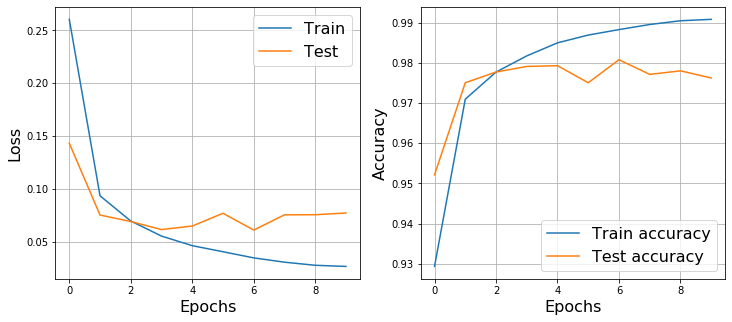

([0.2603753296884774,
  0.09352868766402767,
  0.06970513015707482,
  0.05546217545894767,
  0.04640748755815727,
  0.040654511730085365,
  0.03485095608574368,
  0.03077995276519421,
  0.027854863016345877,
  0.02675527203972064],
 [0.1432435149916365,
  0.0753396293737843,
  0.06923162262839606,
  0.06161008568339144,
  0.06495456080412186,
  0.07701401117764696,
  0.06114590129759045,
  0.07555637545176322,
  0.0756628597626769,
  0.07730142005919656],
 [0.9293099,
  0.97098213,
  0.9777341,
  0.9817653,
  0.98501915,
  0.98695695,
  0.9883174,
  0.98958886,
  0.9905217,
  0.99087155],
 [0.9521361,
  0.9750791,
  0.9777492,
  0.9791337,
  0.9793315,
  0.9750791,
  0.9808149,
  0.97715586,
  0.9780459,
  0.97626585])

In [200]:
from train_utils import train

layers = [
    nn.Linear(196, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 10)
]

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001)

Epoch 9... (Train/Test) NLL: 0.026/0.059	Accuracy: 0.991/0.981


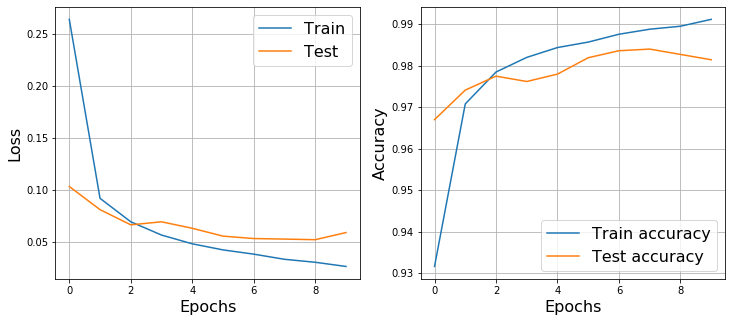

([0.2639741523266792,
  0.09194972242580167,
  0.06941755989721335,
  0.05665147259358817,
  0.048253383014355104,
  0.042389200454744605,
  0.03831472791739301,
  0.033351437660551736,
  0.030495885642680295,
  0.026487104114773535],
 [0.10335117875586582,
  0.08108431313045417,
  0.06648739745628231,
  0.06938974209176967,
  0.06316832191888479,
  0.05561766884867338,
  0.053309888667368056,
  0.05277408599334804,
  0.05219897757066249,
  0.05905132647014306],
 [0.93157536,
  0.97076005,
  0.97845036,
  0.9819763,
  0.9843528,
  0.9856688,
  0.9875622,
  0.98877263,
  0.98948896,
  0.9911492],
 [0.9669699,
  0.9740902,
  0.9774525,
  0.9761669,
  0.977947,
  0.9819027,
  0.98358387,
  0.9839794,
  0.98269385,
  0.98140824])

In [201]:
from train_utils import train

layers = [
    nn.Linear(196, 128),
    LayerNormalization(),
    nn.ReLU(),
    nn.Linear(128, 128),
    LayerNormalization(),
    nn.ReLU(),
    nn.Linear(128, 10)
]

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001)

<i> 3.3 Сделайте выводы по третьей части </i>

В результате применения нормализации сеть стала сходиться до более высокого значения метрики, причем в случае Layer Normalization на тесте метрика была немного выше.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару:

Всё понятно, интересное домашнее задание.